In [1]:
#https://www.zillow.com/research/data/

In [21]:
# Dependencies
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from census import Census
import gmaps
import shapefile as shp
import seaborn as sns
import geopandas as gpd


# Census API Key
from config import census_key_class
from config import gkey
c = Census(census_key_class, year=2013)


In [2]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E","B17001_002E","B25077_001E","B08301_010E",
                          "B15003_022E","B23025_002E","B23025_005E",
                          "B08136_003E","B08136_007E"), {'for': 'zip code tabulation area:*'})





In [5]:

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B25077_001E": "Median Home Value",
                                      "B08301_010E": "Num People Commute Public Transit",
                                      "B15003_022E": "Persons with Bachelor Degree",
                                      "B23025_002E": "People in Labor Force",
                                      "B23025_005E": "People Unemployed",
                                      "B08136_003E": "Solo Auto Commute Time (minutes)",
                                      "B08136_007E": "Public Transport Commute Time (minutes)",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Add in Unemplyment Rate (People Unemployed / People in Labor Force)
census_pd["Unemplyment Rate"] = 100 * \
    census_pd["People Unemployed"].astype(
        int) / census_pd["People in Labor Force"].astype(int)

# Final DataFrame
census_pd = census_pd[["Zipcode", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Poverty Rate",
                       "Median Home Value","Persons with Bachelor Degree",
                       "People in Labor Force","People Unemployed","Unemplyment Rate" ]]

# Visualize
print(len(census_pd))
census_pd.head()

33120


,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Median Home Value,Persons with Bachelor Degree,People in Labor Force,People Unemployed,Unemplyment Rate
0,08518,5217.0,41.5,74286.0,33963.0,170.0,3.258578,206300.0,724.0,3220.0,321.0,9.968944
1,08520,27468.0,37.4,90293.0,37175.0,1834.0,6.676860,291300.0,4878.0,16187.0,1418.0,8.760116
2,08525,4782.0,47.1,118656.0,59848.0,43.0,0.899205,449700.0,1011.0,3004.0,138.0,4.593875
3,08527,54867.0,42.2,88588.0,37021.0,2191.0,3.993293,329500.0,7586.0,29204.0,2910.0,9.964388
4,08528,245.0,48.5,58676.0,49117.0,0.0,0.000000,326800.0,24.0,130.0,0.0,0.000000


In [3]:
#took out:
#"Num People Commute Public Transit"
#"Solo Auto Commute Time (minutes)"
#"Public Transport Commute Time (minutes)"


In [7]:
# Save as a csv
# Note to avoid any issues later, use encoding="utf-8"
census_pd.to_csv("census_data.csv", encoding="utf-8", index=False)

In [11]:
census_pd1= pd.read_csv("census_data.csv")
#Read Richmond MSA Zipcodes Excel (92 zipcodes)
zipcodes_df=pd.read_excel("./Resources/zipcodes.xlsx")
#print(zipcodes_df.count())


In [12]:
#merge census df and zipcode df on zipcode to get data for Richmond MSA (92 zipcodes)
richmond_msa_census = pd.merge(zipcodes_df,census_pd1,how="left", on=['Zipcode','Zipcode'])

# Display the data table for preview
richmond_msa_census.count()

Zipcode                         92
Neighborhood                    92
Population                      92
Median Age                      92
Household Income                92
Per Capita Income               92
Poverty Count                   92
Poverty Rate                    91
Median Home Value               92
Persons with Bachelor Degree    92
People in Labor Force           92
People Unemployed               92
Unemplyment Rate                91
dtype: int64

In [13]:
richmond_msa_census.head()

,Zipcode,Neighborhood,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Median Home Value,Persons with Bachelor Degree,People in Labor Force,People Unemployed,Unemplyment Rate
0,22427,Bowling Green,3702.0,31.5,42232.0,20651.0,447.0,12.074554,196800.0,246.0,2039.0,253.0,12.408043
1,22514,Milford,2451.0,44.6,49271.0,23579.0,239.0,9.751122,147800.0,95.0,1220.0,119.0,9.754098
2,22535,Port Royal,362.0,52.3,51100.0,38654.0,54.0,14.917127,239600.0,41.0,272.0,11.0,4.044118
3,22538,Rappahannock Academy,255.0,42.8,103021.0,33144.0,0.0,0.000000,156300.0,4.0,102.0,0.0,0.000000
4,22546,Ruther Glen,15952.0,36.9,61637.0,26850.0,1976.0,12.387161,186900.0,1312.0,8723.0,1166.0,13.366961


In [14]:
# Save as a csv
# Note to avoid any issues later, use encoding="utf-8"
richmond_msa_census.to_csv("census_data_richmond_msa.csv", encoding="utf-8", index=False)

In [16]:
#get coordinates for Richmond MSA Zipcodes from here:http://download.geonames.org/export/zip/ by downloading US zip to desktop
us_zipcode_coords_df=pd.read_csv("./Resources/zipcode_coords/US.txt", sep='\t', header=None)
# , usecols=[1,9,10] names=["Zipcode", "Lat", "Long"] # this only reads columns we need and names them

us_zipcode_coords_df_renamed=us_zipcode_coords_df.rename(columns={1:"Zipcode", 9:"Lat", 10:"Lng" })

#us_zipcode_coords_df_renamed.head()

us_zipcode_coords_df_clean=us_zipcode_coords_df_renamed.drop([0,2,3,4,5,6,7,8,11], axis=1)
us_zipcode_coords_df_clean.head()

,Zipcode,Lat,Lng
0,99553,54.1430,-165.7854
1,99571,55.1858,-162.7211
2,99583,54.8542,-163.4113
3,99612,55.0628,-162.3056
4,99661,55.3192,-160.4914


In [17]:
#merge richmond_msa_census and us_zipcode_coords_df on Zipcode to get Richmond MSA Census by Zipcode with coordinates 

richmond_msa_data = pd.merge(richmond_msa_census,us_zipcode_coords_df_clean,how="left", on=['Zipcode'])

# Display the data table for preview
print(richmond_msa_data.count())
richmond_msa_data.head()

Zipcode                         92
Neighborhood                    92
Population                      92
Median Age                      92
Household Income                92
Per Capita Income               92
Poverty Count                   92
Poverty Rate                    91
Median Home Value               92
Persons with Bachelor Degree    92
People in Labor Force           92
People Unemployed               92
Unemplyment Rate                91
Lat                             92
Lng                             92
dtype: int64


,Zipcode,Neighborhood,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Median Home Value,Persons with Bachelor Degree,People in Labor Force,People Unemployed,Unemplyment Rate,Lat,Lng
0,22427,Bowling Green,3702.0,31.5,42232.0,20651.0,447.0,12.074554,196800.0,246.0,2039.0,253.0,12.408043,38.0137,-77.1802
1,22514,Milford,2451.0,44.6,49271.0,23579.0,239.0,9.751122,147800.0,95.0,1220.0,119.0,9.754098,38.0058,-77.3185
2,22535,Port Royal,362.0,52.3,51100.0,38654.0,54.0,14.917127,239600.0,41.0,272.0,11.0,4.044118,38.1621,-77.1837
3,22538,Rappahannock Academy,255.0,42.8,103021.0,33144.0,0.0,0.000000,156300.0,4.0,102.0,0.0,0.000000,38.2079,-77.2502
4,22546,Ruther Glen,15952.0,36.9,61637.0,26850.0,1976.0,12.387161,186900.0,1312.0,8723.0,1166.0,13.366961,37.9451,-77.4714


In [18]:
# Save as a csv
# Note to avoid any issues later, use encoding="utf-8"
richmond_msa_data.to_csv("richmond_msa_data_final.csv", encoding="utf-8", index=False)

In [20]:
max_value=richmond_msa_data["Poverty Rate"].max()
max_value


39.13385826771653

In [22]:
# Store 'Lat' and 'Lng' into  locations 
locations = richmond_msa_data[["Lat", "Lng"]].astype(float)


# Convert Poverty Rate to float and store
# HINT: be sure to handle NaN values
poverty_rate = richmond_msa_data["Poverty Rate"].astype(float)

# Create a poverty Heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=poverty_rate, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 0.075)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = False
heat_layer.max_intensity = 40
heat_layer.point_radius = 0.075

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [23]:
#https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-data.2014.html
#pip install pyshp

sns.set(style= "whitegrid", palette="pastel", color_codes=True) 
sns.mpl.rc("figure", figsize=(10,6))


In [28]:
#pip install geopandas
# pip install descartes
# set the filepath and load in a shapefile
map_df = gpd.read_file("./Resources/msa_shapefiles/richmond_msa_zip_shapes_v2.shp")
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,23086,23086,B5,G6350,S,214079105,8271160,+37.6685728,-077.0544136,"POLYGON ((-77.14329599999999 37.70315, -77.143..."
1,23089,23089,B5,G6350,S,156973737,16549281,+37.4557955,-076.9035007,"POLYGON ((-76.935571 37.45016, -76.935569 37.4..."
2,23102,23102,B5,G6350,S,76852096,2649367,+37.7081193,-077.8286536,"POLYGON ((-77.85095 37.744712, -77.85100199999..."
3,23103,23103,B5,G6350,S,96916288,3573755,+37.6480344,-077.7236401,"POLYGON ((-77.776394 37.66745299999999, -77.77..."
4,23106,23106,B5,G6350,S,69705538,987148,+37.7161066,-077.2015109,"POLYGON ((-77.169022 37.708327, -77.1689959999..."


In [29]:
map_df_renamed= map_df.rename(columns={"GEOID10":"Zipcode"})


map_df_renamed.dtypes

ZCTA5CE10     object
Zipcode       object
CLASSFP10     object
MTFCC10       object
FUNCSTAT10    object
ALAND10        int64
AWATER10       int64
INTPTLAT10    object
INTPTLON10    object
geometry      object
dtype: object

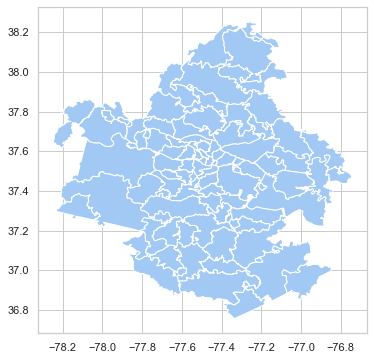

In [30]:
map_df_renamed.plot()

In [31]:
# join the geodataframe with the cleaned up csv dataframe

richmond_msa_data2=richmond_msa_data.astype({'Zipcode': 'str'})

merged_map_df = map_df_renamed.merge(richmond_msa_data2, on="Zipcode")
merged_map_df.head()



,ZCTA5CE10,Zipcode,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,...,Per Capita Income,Poverty Count,Poverty Rate,Median Home Value,Persons with Bachelor Degree,People in Labor Force,People Unemployed,Unemplyment Rate,Lat,Lng
0,23086,23086,B5,G6350,S,214079105,8271160,+37.6685728,-077.0544136,"POLYGON ((-77.14329599999999 37.70315, -77.143...",...,26269.0,319.0,11.792976,188400.0,194.0,1529.0,16.0,1.046436,37.7202,-77.0998
1,23089,23089,B5,G6350,S,156973737,16549281,+37.4557955,-076.9035007,"POLYGON ((-76.935571 37.45016, -76.935569 37.4...",...,30892.0,820.0,16.350947,272800.0,648.0,2725.0,404.0,14.825688,37.4194,-76.9027
2,23102,23102,B5,G6350,S,76852096,2649367,+37.7081193,-077.8286536,"POLYGON ((-77.85095 37.744712, -77.85100199999...",...,32064.0,35.0,1.047277,328100.0,426.0,1448.0,48.0,3.314917,37.7126,-77.8315
3,23103,23103,B5,G6350,S,96916288,3573755,+37.6480344,-077.7236401,"POLYGON ((-77.776394 37.66745299999999, -77.77...",...,67963.0,134.0,3.058662,534700.0,1091.0,2310.0,112.0,4.848485,37.6380,-77.7077
4,23106,23106,B5,G6350,S,69705538,987148,+37.7161066,-077.2015109,"POLYGON ((-77.169022 37.708327, -77.1689959999...",...,16816.0,497.0,39.133858,200200.0,59.0,445.0,15.0,3.370787,37.7184,-77.1860


In [32]:
merged_map_df.to_csv("merged_map_data.csv", encoding="utf-8", index=False)


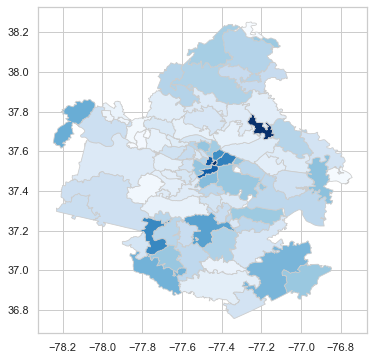

In [34]:
# set a variable that will call whatever column we want to visualise on the map
variable = "Poverty Rate"
# set the range for the choropleth
vmin, vmax = 0, 50
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
# create map
merged_map_df.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")
plt.savefig("map1",bbox_inches="tight", dpi = 300)